### Install

In [ ]:
aggregation_functions = ['avg', 'sum', 'max', 'min', 'count']
group_by_columns = [
    'workclass',
    'education',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
]
measure_columns = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [376]:
#pip install ucimlrepo

### Imports

In [378]:
# Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import psycopg2
from collections import defaultdict
from scipy import stats as kl
from decimal import Decimal
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from itertools import product
import matplotlib.pyplot as plt
from itertools import product


In [379]:
# connection = psycopg2.connect(database="Project645", user="vaishnavishah", password="10jan2001", host="localhost", port=5432)
connection = psycopg2.connect(database="Project645", user="postgres", password="Rajada1234@", host="localhost", port=5433)
#connection = psycopg2.connect(database="seedb", user="postgres", password="nineten910", host="localhost", port=5432)
cursor = connection.cursor()


In [380]:
query = "select workclass, sum(age) from married where workclass is not null group by workclass order by workclass;"

cursor.execute(query)
record = cursor.fetchall()
print(record)

[('Federal-gov', 162705), ('Local-gov', 341280), ('Private', 3027550), ('Self-emp-inc', 293510), ('Self-emp-not-inc', 607870), ('State-gov', 194815), ('Without-pay', 4005)]


In [381]:
eps = np.finfo(float).eps  # smallest float such that 1.0 + eps != 1.0

In [382]:
def create_initial_list_of_views(grouping_columns, measure_columns, aggregation_functions):
    # print(list(product(grouping_columns, aggregation_functions, measure_columns)))
    return list(product(grouping_columns, aggregation_functions, measure_columns))

In [383]:
def distance(target, reference, measure='kld'):

    target = dict(target)
    reference = dict(reference)

    t = list()
    r = list()

    # we need this because this ensures that there are the same number of categories in each distribution
    for key in set().union(target.keys(), reference.keys()):
        t_val = float(target.get(key, 0))
        r_val = float(reference.get(key, 0))
        t.append(t_val)
        r.append(r_val)


    # normalize to create a probability distribution
    t = np.asarray(t) / (np.sum(t) or 1.0)
    r = np.asarray(r) / (np.sum(r) or 1.0)
    t = [max(x, eps) for x in t]
    r = [max(x, eps) for x in r]


    return entropy(t, r)

In [384]:
def group_views_by_grouping_column(views_in_the_running):
    grouped_views = dict()
    for view in views_in_the_running:
        grouper = view[0]
        if grouper in grouped_views:
            grouped_views[grouper].append(view)
        else:
            grouped_views[grouper] = [view]
    return grouped_views
# group_views_by_grouping_column(create_initial_list_of_views(group_by_columns, measure_columns, aggregation_functions))

In [385]:
def hoeffding_serfling_interval(phase, num_phases, delta):
    phase = float(phase)
    num_phases = float(phase)
    numerator = (1 - ((phase - 1) / num_phases)) * (2 * np.log(np.log(phase)) + np.log((np.pi * np.pi) / (3 * delta)))
    epsilon_m = np.sqrt(numerator / (2 * phase))
    return epsilon_m

In [386]:
def create_adult_table(conn, cur):
    # Create table cleandata
    cur.execute("DROP TABLE IF EXISTS Adult CASCADE;")
    cur.execute("""
        CREATE TABLE IF NOT EXISTS cleandata (
            age INT,
            workclass VARCHAR(100),
            fnlwgt INT,
            education VARCHAR(100),
            education_num INT,
            marital_status VARCHAR(100),
            occupation VARCHAR(100),
            relationship VARCHAR(100),
            race VARCHAR(100),
            sex VARCHAR(10),
            capital_gain INT,
            capital_loss INT,
            hours_per_week INT,
            native_country VARCHAR(100)
        );
    """)
    # Fill in table from csv file
    with open('/Users/riya/Desktop/College/Compsci645/SeeDB_Implementation/cleandata.csv', 'r') as f:
        cur.copy_from(f, 'cleandata', sep=',', columns=(
            'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'))
    cur.execute("alter table adult add column id serial primary key;")
    conn.commit()


In [387]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country

In [388]:
def create_ref_tgt_views(conn, cur):
    # Create Target table
    # cur.execute("DROP TABLE IF EXISTS unmarried;")
    # cur.execute("DROP TABLE IF EXISTS married;")
    cur.execute("DROP VIEW IF EXISTS unmarried;")
    cur.execute("""
        CREATE VIEW unmarried AS
        SELECT * FROM cleandata WHERE marital_status = 'Unmarried';
    """)
    # Create Reference table (Complement of Target)
    cur.execute("DROP VIEW IF EXISTS married;")
    cur.execute("""
        CREATE VIEW married AS
        SELECT * FROM cleandata WHERE marital_status = 'Married';
    """)

    conn.commit()

In [389]:
def naive_search(cur, list_of_views, limits=None, top_k=5, measure='kld', verbose=False):
    '''
    Exhaustively iterate over all combinations of triplets and query the database
    '''

    grouped_views = group_views_by_grouping_column(list_of_views)

    query = "select {group}, {func}({m_col}) from {table} {where} group by {group};"



    results = list()
    for group, views in grouped_views.items():
        for view in views:
            _, func, m_col = view
            target_query = query.format(group=group,
                                        func=func,
                                        m_col=m_col,
                                        table='married',
                                        )

            cur.execute(target_query)
            target_results = cur.fetchall()

            reference_query = query.format(group=group,
                                           func=func,
                                           m_col=m_col,
                                           table='unmarried',
                                           )
            cur.execute(reference_query)
            reference_results = cur.fetchall()

            dist = distance(target_results, reference_results)
            results.append((view, dist))

            if verbose:
                print ("{}, {}, {}".format(group, func, m_col), dist)

    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]


In [390]:
def sharing_based_search(cur, list_of_views, limits=None, top_k=5, measure='kld', verbose=False):
    '''
    Apply Sharing optimizations by grouping multiple aggrerations within the same query
    '''

    grouped_views = group_views_by_grouping_column(list_of_views)

    query = "select {group} {aggregated_measures} from {table} {where} group by {group};"

    results = list()
    for group, views in grouped_views.items():

        q_string = "".join(", {func}({m_col})".format(func=func, m_col=m_col) for _, func, m_col in views)
        where_clause=""
        target_query = query.format(group=group,
                                    aggregated_measures=q_string,
                                    table='married',
                                    where=where_clause
                                    )
        cur.execute(target_query)
        t_v = cur.fetchall()

        reference_query = query.format(group=group,
                                       aggregated_measures=q_string,
                                       table='unmarried',
                                       where=where_clause)
        cur.execute(reference_query)
        r_v = cur.fetchall()

        for i, view in enumerate(views):
            target_results = [(v[0], v[i+1]) for v in t_v]
            reference_results = [(v[0], v[i+1]) for v in r_v]

            dist = distance(target_results, reference_results, measure=measure)
            if verbose:
                print( view, dist)
            results.append((view, dist))


    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]

In [391]:
def pruning_based_search(cur, list_of_views, search_method, num_partitions=15, top_k=5, measure='kld', verbose=False):
    '''
    Apply pruning optimizations based on Confidence Intervals derived from Hoeffding-Serfling inequality
    '''

    
    current_views = list_of_views[:]

    mean_estimated_utility = dict()

    for i in range(num_partitions):

        # this returns the results in sorted order!
        results = search_method(cur, current_views, limits=None, top_k=None, measure=measure)

        for view, utility in results:
            prev_mean = mean_estimated_utility.get(view, 0.0)
            mean_estimated_utility[view] = (i * prev_mean + utility) / (i + 1)

        sorted_utilities = sorted([mean_estimated_utility[view] for view in current_views])

        max_utility = sorted_utilities[-1]
        kth_utility = sorted_utilities[-top_k] / max_utility

        if i == 0:
            if verbose:
                print("We dont want to cull anything on the first iteration because epsilon is NaN")
            continue
        epsilon_m = hoeffding_serfling_interval(i+1, num_partitions, 0.1)
        not_pruned_views = list()

        for view in current_views:
            est_util = mean_estimated_utility[view] / max_utility
            if (est_util + epsilon_m) >= (kth_utility - epsilon_m):
                not_pruned_views.append(view)

        culled = len(current_views) - len(not_pruned_views)

        if verbose:
            print("On iterated %d we pruned %d views." % (i, culled))

        current_views = not_pruned_views[:]

    if verbose:
        print("we finished with %d views." % len(current_views))


    return search_method(cur, current_views, top_k=top_k, measure=measure)


('relationship', 'sum', 'capital_gain') 35.15956612486812


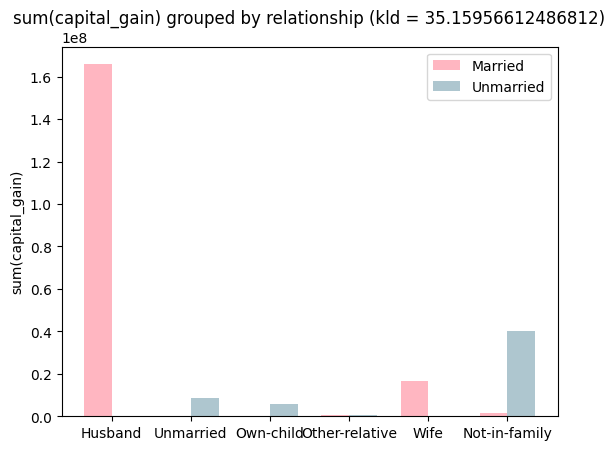

('relationship', 'sum', 'capital_loss') 34.877476735122976


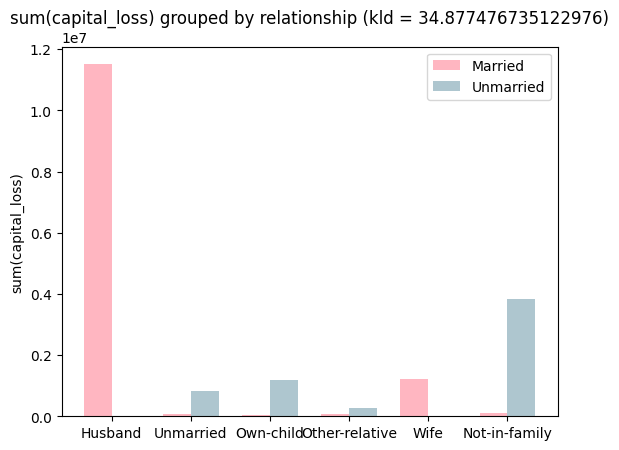

('relationship', 'sum', 'age') 34.29606419439562


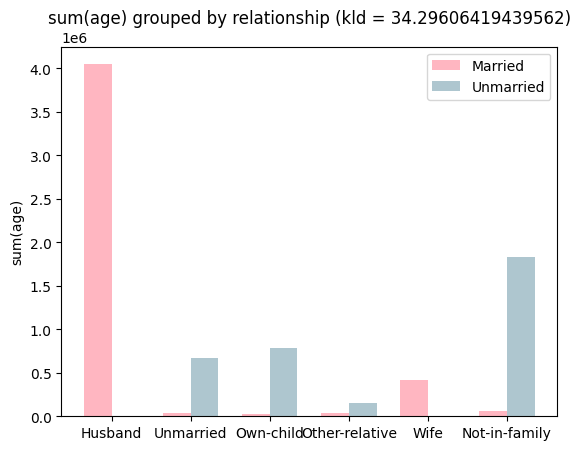

('relationship', 'sum', 'hours_per_week') 34.276281101060064


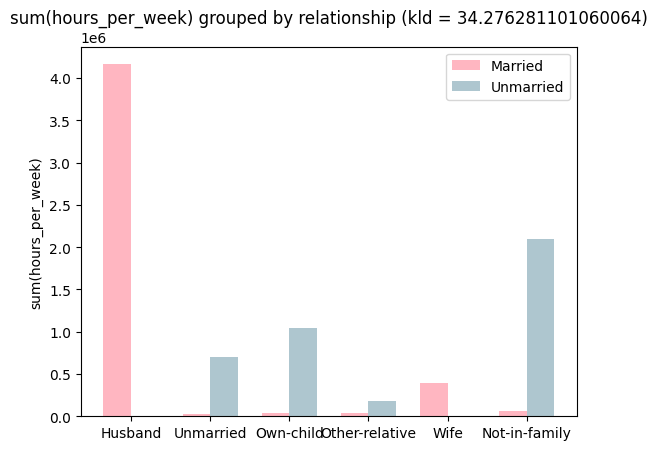

('relationship', 'sum', 'education_num') 34.26413048422267


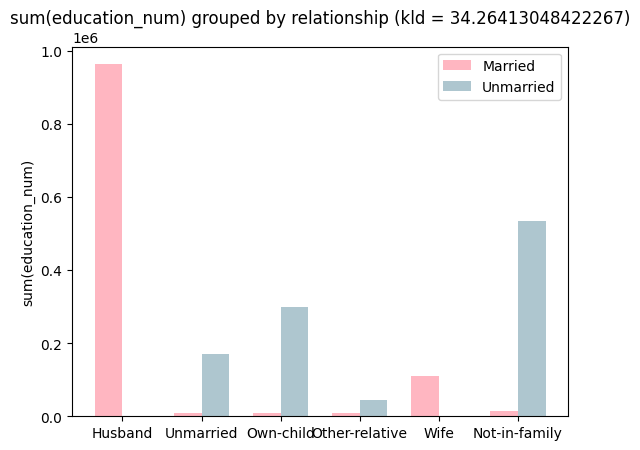

In [396]:
if __name__ == "__main__":
    connection = psycopg2.connect(database="Project645", user="postgres", password="Rajada1234@", host="localhost", port=5433)
    cursor = connection.cursor()

    #create_adult_table(connection, cursor)
    #create_ref_tgt_views(connection, cursor)
    #connection.commit()


    init_list = create_initial_list_of_views(group_by_columns, measure_columns, aggregation_functions)

    measure = 'kld'


    for i in range(1):
        #top_5 = pruning_based_search(cursor, init_list, sharing_based_search, measure=measure, verbose=True)

        top_5 = sharing_based_search(cursor, init_list, verbose=False, measure=measure)

    for view, utility in top_5:
        print (view, utility)

        cursor.execute("select {g}, {f}({m}) from married group by {g};".format(g=view[0], f=view[1], m=view[2]))
        target = dict(cursor.fetchall())

        cursor.execute("select {g}, {f}({m}) from unmarried group by {g};".format(g=view[0], f=view[1], m=view[2]))
        reference = dict(cursor.fetchall())

        t = list()
        r = list()
        names = list()

        # we need this because this ensures that there are the same number of categories in each distribution
        for key in set().union(target.keys(), reference.keys()):
            names.append(key)
            t_val = float(target.get(key, 0))
            r_val = float(reference.get(key, 0))
            t.append(t_val)
            r.append(r_val)
        
    #     fig, ax = plt.subplots()

    #     width=0.35
    #     index = np.arange(len(names))

    #     t_bar = ax.bar(index, t, width, color='r')

    #     r_bar = ax.bar(index+width, r, width, color='b')

    #     ax.set_title("{f}({m}) grouped by {g} ({measure} = {util})".format(f=view[1],
    #                                                                        m=view[2],
    #                                                                        g=view[0],
    #                                                                        measure=measure,
    #                                                                        util=utility))
    #     ax.set_ylabel("{f}({m})".format(f=view[1], m=view[2]))
    #     ax.set_xticks(index + width/2)
    #     ax.set_xticklabels(names)
    #     ax.legend((t_bar[0], r_bar[0]), ('Married', 'Unmarried'))

    # plt.show()
            
        import matplotlib.pyplot as plt

        # Create a figure and axis object
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

        # Define light pink and pastel colors
        light_pink = '#FFB6C1'  # Light Pink
        pastel_blue = '#AEC6CF'  # Pastel Blue

        # Create bar plots with the chosen colors
        t_bar = ax.bar(index, t, width, color=light_pink)
        r_bar = ax.bar(index + width, r, width, color=pastel_blue)

        # Customize plot title and labels
        ax.set_title("{f}({m}) Grouped by {g} (Measure = {measure}, Utility = {util})".format(f=view[1],
                                                                                            m=view[2],
                                                                                            g=view[0],
                                                                                            measure=measure,
                                                                                            util=utility),
                    fontsize=16, color='navy')  # Adjust title font size and color
        ax.set_ylabel("{f}({m})".format(f=view[1], m=view[2]), fontsize=14, color='purple')  # Adjust y-label font size and color
        ax.set_xlabel("Categories", fontsize=14, color='green')  # Adjust x-label font size and color
        ax.set_xticks(index + width / 2)
        ax.set_xticklabels(names, fontsize=12, color='gray', rotation=45)  # Adjust x-tick label font size, color, and rotation

        # Add legend with custom labels and colors
        ax.legend((t_bar[0], r_bar[0]), ('Married', 'Unmarried'), loc='upper right', fontsize=12)

        # Customize grid lines
        ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')  # Add grid lines with customized style

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show plot
        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()




    connection.commit() # close the transaction on the database
    cursor.close()
    connection.close()

In [394]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country